# Ingredient intake evolution

In [2]:
### Import packages

import numpy as np
import pandas as pd
import calendar
import matplotlib.pyplot as plt

In [3]:
### Define constants

PLOT_DIR = 'plots/'
CSV_DIR = 'csv/'

PLOT_CONFIG = {'title': 18,
              'subtitle': 16,
              'label': 14,
              'tick': 12,
              'legend': 14}

In [4]:
### Define functions

def save_plot_data(df, filename):
    with open(PLOT_DIR + filename + '.csv', 'w') as f:
        df.to_csv(f, index = False, sep = ';')
        
def plot_stackplot(df, COL, ax, OTHER = True, NORMALISE = False):

    df_dist = df[[COL, 'qnt_ingredients', 'colour']].groupby([COL, 'colour'], as_index = False).sum()
    df_dist['dist'] = np.round(df_dist['qnt_ingredients'] / df_dist['qnt_ingredients'].sum(), 5)
    df_dist['order'] = df_dist['qnt_ingredients']

    df_dist.loc[(df_dist[COL].str.lower() == 'other') & OTHER, 'order'] = 0
    df_dist.sort_values(by = 'order', inplace = True)

    ORDER = df_dist[COL].to_list()
    COLOURS = df_dist['colour'].to_list()

    # Sumarised data
    df_dist_plot = pd.pivot_table(data = df,
                                    index = 'cutoff_date',
                                    columns = COL,
                                    values = 'qnt_ingredients',
                                    aggfunc = 'sum')

    df_dist_plot.fillna(0, inplace = True)
    df_dist_plot = df_dist_plot[ORDER]

    if NORMALISE:
        df_dist_plot['total'] = df_dist_plot.sum(axis = 1)
        for i in ORDER:
            df_dist_plot[i] = df_dist_plot[i] * 1.0 / df_dist_plot['total']

        df_dist_plot.drop(columns = 'total', inplace = True)

    df_dist_plot.plot.area(ax = ax,
                          color = COLOURS,
                          legend = None)
    
    return df_dist;

def plot_formatting(ax, parameters, config = PLOT_CONFIG, ignore_ticks = False, has_legend = False):
    
    # Set labels
    ax.set_xlabel(parameters['x_label'], fontsize = config['label'])
    ax.set_ylabel(parameters['y_label'], fontsize = config['label'])
    
    # Set title
    if('title' in parameters.keys()):
        ax.set_title(parameters['title'], fontsize = config['title'])
        
    # Set subtitle
    if('subtitle' in parameters.keys()):
        ax.set_title(parameters['subtitle'], fontsize = config['subtitle'])
    
    # Set tick size
    if(not ignore_ticks):
        ax.tick_params(axis = 'both', which = 'major', labelsize = config['tick'])
    
    # Set legend
    if(has_legend):
        ax.legend(loc = 'best', fontsize = config['legend'])

In [5]:
### Read files

with open(CSV_DIR + 'ingredient_timeseries.csv', 'r') as f:
    df_ingredients = pd.read_csv(f, sep = ';')
    
df_ingredients.head()

,cutoff_date,category_id,category,qnt_ingredients
0,2021-01-01,101,Fish & Seafoods,61
1,2021-01-01,102,Meat & Poultry,219
2,2021-01-01,103,Vegetables,227
3,2021-01-01,104,Z Herbs (Old Category),22
4,2021-01-01,105,Nuts & Seeds,19


In [6]:
### Compute most popular categories

df_categories = df_ingredients[['category_id', 'category', 'qnt_ingredients']].groupby(['category_id', 'category'], as_index = False).sum()
df_categories.sort_values(by = 'qnt_ingredients', ascending = False, inplace = True)
df_categories.reset_index(drop = True, inplace = True)

In [7]:
### Define categories

TOP_CATEGORIES = df_categories['category_id'].head().to_list()

# Categories defined by domain expertise
GROUPED_CATEGORIES = {'raw': [102, 103, 107, 101, 148, 108, 109, 153, 110, 113, 105, 106, 104, 112],
                     'beverages': [141, 115, 149, 116, 119, 117, 114, 140, 124, 120, 122]}

GROUPED_CATEGORIES['processed'] = [i for i in df_categories['category_id'].to_list() if(i not in GROUPED_CATEGORIES['raw'] and i not in GROUPED_CATEGORIES['beverages'])]

GROUPED_CATEGORIES_INV = {y: x for x, CATS in GROUPED_CATEGORIES.items() for y in CATS}

In [8]:
### Define colours

TOP_CATEGORIES_COLOURS = {'Meat & Poultry': '#f0d06b',
                         'Prepared Foods/Meals': '#d95a40',
                         'Vegetables': '#bf2742',
                         'Cold Beverages': '#501e31',
                         'Desserts': '#577c80',
                         'Other': '#888888'}

GROUPED_CATEGORIES_COLOURS = {'raw': '#0488c2',
                             'beverages': '#03a086',
                             'processed': '#f7d40c'}

In [9]:
### Plot timelines

df_ingredients_plot = df_ingredients.copy()
df_ingredients_plot['group'] = df_ingredients_plot['category_id'].map(GROUPED_CATEGORIES_INV)

df_ingredients_plot['top'] = 'Other'
df_ingredients_plot.loc[df_ingredients_plot['category_id'].isin(TOP_CATEGORIES), 'top'] = df_ingredients_plot['category']

df_ingredients_plot['cutoff_date'] = pd.to_datetime(df_ingredients_plot['cutoff_date'])
df_ingredients_plot['month_num'] = df_ingredients_plot['cutoff_date'].dt.month
df_ingredients_plot['month'] = df_ingredients_plot['month_num'].apply(lambda x: calendar.month_abbr[x])
df_ingredients_plot['year'] = df_ingredients_plot['cutoff_date'].dt.year
df_ingredients_plot['year_str'] = df_ingredients_plot['year'].apply(str)
df_ingredients_plot['month_axis'] = df_ingredients_plot['month'] + '-' + df_ingredients_plot['year_str'].str[2:4]

# Compute top ingredients
df_ingredients_top = df_ingredients_plot[['cutoff_date', 'top', 'qnt_ingredients', 'month_axis']]
df_ingredients_top = df_ingredients_top.groupby(['cutoff_date', 'top', 'month_axis'], as_index = False).sum()
df_ingredients_top.sort_values(by = ['cutoff_date', 'top'], inplace = True)
df_ingredients_top['colour'] = df_ingredients_top['top'].map(TOP_CATEGORIES_COLOURS)

save_plot_data(df_ingredients_top, 'ingredients_top')

# Compute group ingredients
df_ingredients_group = df_ingredients_plot[['cutoff_date', 'group', 'qnt_ingredients', 'month_axis']]
df_ingredients_group = df_ingredients_group.groupby(['cutoff_date', 'group', 'month_axis'], as_index = False).sum()
df_ingredients_group.sort_values(by = ['cutoff_date', 'group'], inplace = True)
df_ingredients_group['colour'] = df_ingredients_group['group'].map(GROUPED_CATEGORIES_COLOURS)

save_plot_data(df_ingredients_group, 'ingredients_group')

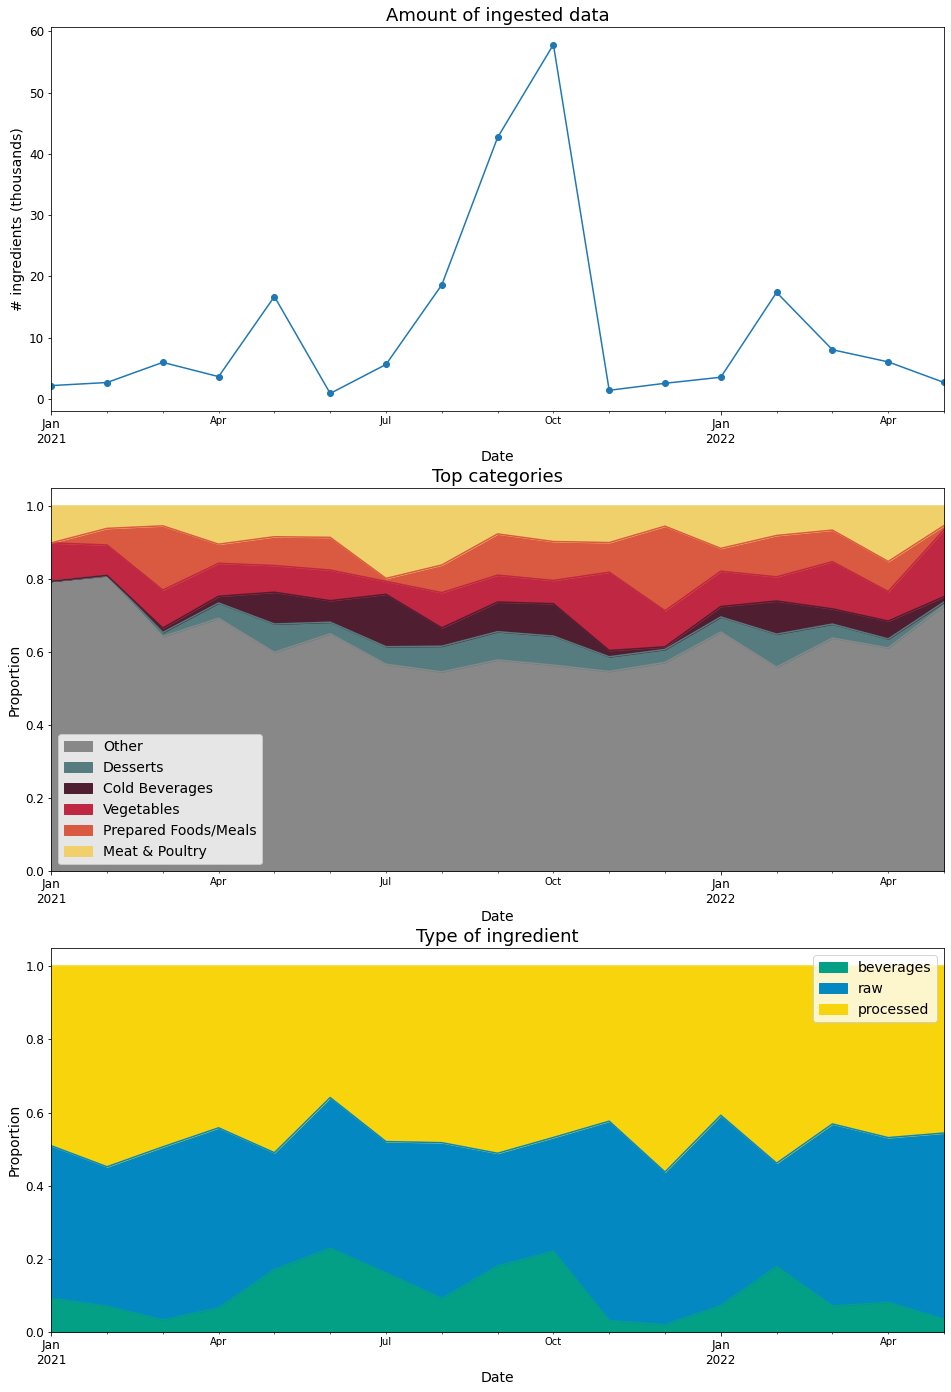

In [10]:
### Plot figures

fig, axs = plt.subplots(3, 1, figsize = (16, 24)) # Create figure and axes

# Plot quantity
df_general_plot = df_ingredients_plot[['cutoff_date', 'qnt_ingredients']].groupby('cutoff_date').sum()

save_plot_data(df_general_plot.reset_index(), 'ingredients_general')

df_general_plot['qnt_ingredients'] = df_general_plot['qnt_ingredients'] / 1000 # Thousands
df_general_plot.plot(ax = axs[0],
                    legend = None,
                    marker = 'o')

plot_params = {'title': 'Amount of ingested data',
             'x_label': 'Date',
             'y_label': '# ingredients (thousands)'}

plot_formatting(axs[0], plot_params)

# Plot top data
df_plot_top_dist = plot_stackplot(df_ingredients_top, 'top', axs[1], NORMALISE = True)

plot_params = {'title': 'Top categories',
             'x_label': 'Date',
             'y_label': 'Proportion'}

plot_formatting(axs[1], plot_params, has_legend = True)

# Plot top data
df_plot_group_dist = plot_stackplot(df_ingredients_group, 'group', axs[2], OTHER = False, NORMALISE = True)

plot_params = {'title': 'Type of ingredient',
             'x_label': 'Date',
             'y_label': 'Proportion'}

plot_formatting(axs[2], plot_params, has_legend = True)

plt.show()

# Save figure
fig.savefig(PLOT_DIR + 'time_evolution_ingestion.png', dpi = 144)